In [1]:
import nibabel as nib
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

if not os.path.exists('result'):
    os.makedirs('result')

In [2]:
def load_nii(df, img_type_list=['BIANCA', 'LGA', 'LPA', 'SPM12', 'Label']):
    dict_img = dict()
    dict_img['ID'] = df['ID']
    dict_img['Model'] = df['Model']
    for img_type in img_type_list:
        _img = []
        for subj_id in df['ID']:
            img_path = "data/2_prep/{}/{}_RS.nii.gz".format(img_type, subj_id)
            _img.append(nib.load(img_path).get_fdata())
        dict_img[img_type] = _img
    return dict_img

def dice_coff(x, y):
    x = x.reshape(-1)
    y = y.reshape(-1)
    return 2 * np.sum(((x==y)&(x==1)&(y==1)) / float(sum(map(len, (x[x==1], y[y==1])))))
            

def plot_Dice_thr(dict_img_data, img_type_list=['BIANCA', 'LGA', 'LPA', 'SPM12'], thr_list=np.arange(0,1.05,0.05)):
    dict_dice_data = dict()
    dict_dice_data['Thr'] = thr_list
    for img_type in img_type_list:
        label = np.array(dict_img_data['Label'])
        _dice_coff_list = []
        for thr in thr_list:
            _img = np.where(dict_img_data[img_type] < thr, 0, 1)
            _dice_coff_list.append(dice_coff(_img.reshape(-1), label.reshape(-1)))
        dict_dice_data[img_type] = _dice_coff_list
    df_dice = pd.DataFrame(dict_dice_data)
    df_dice.to_csv('result/optimize_DSC_thr.csv', index=False)
    
    # Plot
    df_dice_melt = pd.melt(df_dice, 
            id_vars='Thr', 
            var_name='Software', 
            value_name='DSC', 
            col_level=None)
    sns.relplot(x='Thr', y='DSC', hue='Software', data=df_dice_melt, kind='line', markers=True, dashes=False)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()
    
    # Optimal value
    for software in df_dice.columns[1:]:
        _df_dice_max = df_dice.loc[df_dice[software]==df_dice[software].max(), ['Thr', software]]
        print("{}, DSC(optimal cutoff): {:.3f} ({:.3f})".format(software, _df_dice_max[software].values[0], _df_dice_max['Thr'].values[0]))
    return df_dice

In [3]:
filename = 'data/data_list.csv'
df = pd.read_csv(filename)
img_data = load_nii(df)

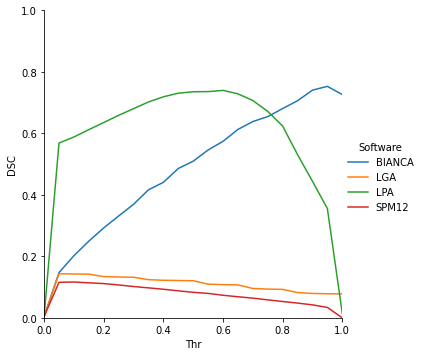

BIANCA, DSC(optimal cutoff): 0.753 (0.950)
LGA, DSC(optimal cutoff): 0.143 (0.050)
LPA, DSC(optimal cutoff): 0.740 (0.600)
SPM12, DSC(optimal cutoff): 0.116 (0.100)


In [4]:
# Calc DSC
df_dice = plot_Dice_thr(img_data)
# df_dice.head()